# Set up

In [ ]:
# Set up environment
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
# Testing parameters: Only run on N samples if test=True
test = False
max_sample_test = 1000
# Maximum length of equation in # of tokens
max_length_token = 100
# Size of vocab in tokenizer, i.e. distinct number of tokens to learn
vocab_size = 600
# Batch size for DataLoader
batch_size = 256
# Report loss every N steps
report_step = 100
# Number of epochs to train. Each epoch is one cycle of training over full training set.
num_epoch = 3

In [ ]:
# Only run once per session

! if [ ! $pip_done ]; then pip install -q transformers ;fi
! if [ ! $pip_done ]; then pip install -q datasets jiwer ;fi
! if [ ! $pip_done ]; then pip install -q sentencepiece ;fi

pip_done = 1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 27.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


In [ ]:
!mkdir "./im2latex/formula_images_processed/"
!tar -xzvf "./im2latex/formula_images_processed.tar.gz" -C "./im2latex/formula_images_processed/"

Streaming output truncated to the last 5000 lines.
formula_images_processed/2fd043ff12.png
formula_images_processed/13bc271ff3.png
formula_images_processed/2b79e5b4ac.png
formula_images_processed/4ac129c519.png
formula_images_processed/1e726fd231.png
formula_images_processed/5d4b9c93f8.png
formula_images_processed/2c9e83e49f.png
formula_images_processed/588e67053f.png
formula_images_processed/776b7aa296.png
formula_images_processed/2085709134.png
formula_images_processed/758643d2f3.png
formula_images_processed/4225049065.png
formula_images_processed/18772883f6.png
formula_images_processed/6f7916d09d.png
formula_images_processed/e48d8d3334.png
formula_images_processed/4c16568130.png
formula_images_processed/73e318a2ca.png
formula_images_processed/526bab6f90.png
formula_images_processed/63f70fb534.png
formula_images_processed/1d348a882e.png
formula_images_processed/4265ab8fc3.png
formula_images_processed/21c0eaa8fe.png
formula_images_processed/18f5d5dacc.png
formula_images_processed/26d0

In [ ]:
!ls im2latex
!head im2latex/im2latex_train_filter.lst

formula_images_processed	 im2latex_formulas.tok.lst  im2latex_validate_filter.lst
formula_images_processed.tar.gz  im2latex_test_filter.lst   readme.txt
im2latex_formulas.norm.lst	 im2latex_train_filter.lst
66667cee5b.png 2
1cbb05a562.png 3
ed164cc822.png 4
e265f9dc6b.png 5
242a58bc3a.png 7
a4d25113b2.png 8
72f6bc494a.png 9
3cf9d0b234.png 12
5be376c443.png 13
4dd5a0e4ad.png 15


In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', 1000)

In [ ]:
# IPython magic to enable inline display of matplotlib plots
%matplotlib inline
from IPython.display import Image as ipyImage
from IPython.display import display, Latex

In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from os.path import join

data_dir = './im2latex/formula_images_processed/'
filter_dir = './im2latex/'

formulas_file = join(filter_dir, "im2latex_formulas.norm.lst")
with open(formulas_file, 'r') as f:
    formulas = [formula.strip('\n') for formula in f.readlines()]

train_df = pd.read_csv(join(filter_dir, 'im2latex_train_filter.lst'), header=None, sep=' ')
train_df.rename(columns={0: "file_name", 1: "text_index"}, inplace=True)


In [ ]:
# Replace text with formulas
train_df['text'] = train_df.apply(lambda row: formulas[int(row['text_index'])], axis=1)
train_df['len'] = train_df.apply(lambda row: row['text'].count(' '), axis=1)

train_df.reset_index(drop=True, inplace=True)

In [ ]:
train_df.head()

,file_name,text_index,text,len
0,66667cee5b.png,2,\widetilde \gamma _ { \mathrm { h o p f } } \simeq \sum _ { n > 0 } \widetilde { G } _ { n } { \frac { ( - a ) ^ { n } } { 2 ^ { 2 n - 1 } } },50
1,1cbb05a562.png,3,"( { \cal L } _ { a } g ) _ { i j } = 0 , \ \ \ \ ( { \cal L } _ { a } H ) _ { i j k } = 0 ,",42
2,ed164cc822.png,4,S _ { s t a t } = 2 \pi \sqrt { N _ { 5 } ^ { ( 1 ) } N _ { 5 } ^ { ( 2 ) } N _ { 5 } ^ { ( 3 ) } } \left( \sqrt { n } + \sqrt { \bar { n } } \right),60
3,e265f9dc6b.png,5,"\hat { N } _ { 3 } = \sum \sp f _ { j = 1 } a _ { j } \sp { \dagger } a _ { j } \, .",33
4,242a58bc3a.png,7,"\, ^ { * } d \, ^ { * } H = \kappa \, ^ { * } d \phi = J _ { B } .",27


47413    B = C = 0 \, , \quad A = F \, , \quad D ^ { - 1 } = F ^ { T } \, , \quad \operatorname* { d e t } F = \pm 1 \, ,
Name: text, dtype: object


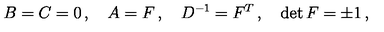

In [ ]:
# Show some images as sanity check
sample = train_df.sample(n=1)
print(sample['text'])
ipyImage(join(data_dir, 'formula_images_processed', sample.iloc[0]['file_name']))

In [ ]:
eval_df = pd.read_csv(join(filter_dir, 'im2latex_validate_filter.lst'), header=None, sep=' ')
eval_df.rename(columns={0: "file_name", 1: "text_index"}, inplace=True)

test_df = pd.read_csv(join(filter_dir, 'im2latex_test_filter.lst'), header=None, sep=' ')
test_df.rename(columns={0: "file_name", 1: "text_index"}, inplace=True)

In [ ]:
eval_df['text'] = eval_df.apply(lambda row: formulas[int(row['text_index'])], axis=1)
eval_df['len'] = eval_df.apply(lambda row: row['text'].count(' '), axis=1)

test_df.reset_index(drop=True, inplace=True)

test_df['text'] = test_df.apply(lambda row: formulas[int(row['text_index'])], axis=1)
test_df['len'] = test_df.apply(lambda row: row['text'].count(' '), axis=1)

test_df.reset_index(drop=True, inplace=True)

In [ ]:
eval_df.head()

,file_name,text_index,text,len
0,5abbb9b19f.png,0,"\int _ { - \epsilon } ^ { \infty } d l \: \mathrm { e } ^ { - l \zeta } \int _ { - \epsilon } ^ { \infty } d l ^ { \prime } \mathrm { e } ^ { - l ^ { \prime } \zeta } l l ^ { \prime } { \frac { l ^ { \prime } - l } { l + l ^ { \prime } } } \{ 3 \, \delta ^ { \prime \prime } ( l ) - { \frac { 3 } { 4 } } t \, \delta ( l ) \} = 0 .",111
1,329a44c373.png,65546,"[ { \bar { K } } _ { a } ^ { - } ( p ) , { \bar { K } } _ { b } ^ { - } ( k ) ] = i f _ { a b c } { \bar { K } } _ { c } ^ { - } ( p + k ) - 2 { \pi } ^ { 2 } C p { \delta } _ { a b } { \delta } _ { p + k , 0 } .",95
2,73b51f198b.png,38231,"E ( v ) = \frac { d } { d t } E ( q ) \; \; \; \; \; \; \; \forall t \, .",27
3,6331d9e7fd.png,43693,{ \frac { 1 } { L ^ { 2 } } } \prod _ { i = 1 } ^ { 3 } ( r _ { + } ^ { 2 } + q _ { i } ) - \mu r _ { + } ^ { 2 } \sim 0 \ .,55
4,91a55d2cb9.png,32786,"x ^ { I } ( \sigma + 2 \pi , \tau ) = x ^ { I } ( \sigma , \tau ) + 2 \pi L ^ { I } .",32


In [ ]:
test_df.head()

,file_name,text_index,text,len
0,7944775fc9.png,32771,"\alpha _ { 1 } ^ { r } \gamma _ { 1 } + \dots + \alpha _ { N } ^ { r } \gamma _ { N } = 0 \quad ( r = 1 , . . . , R ) \; ,",46
1,78228211ca.png,32772,\eta = - \frac { 1 } { 2 } \operatorname { l n } \left( \frac { \operatorname { c o s h } \left( \sqrt { 2 } b _ { \infty } \sqrt { 1 + \alpha ^ { 2 } } \; y - \mathrm { a r c s i n h } \; \alpha \right) } { \sqrt { 1 + \alpha ^ { 2 } } } \right),74
2,15b9034ba8.png,11,"P _ { ( 2 ) } ^ { - } = \int \beta d \beta d ^ { 9 } p d ^ { 8 } \lambda \Phi ( - p , - \lambda ) \left( - \frac { p ^ { I } p ^ { I } } { 2 \beta } \right) \Phi ( p , \lambda ) \, .",63
3,6968dfca15.png,14185,"\Gamma ( z + 1 ) = \int _ { 0 } ^ { \infty } \, \, d x \, \, e ^ { - x } x ^ { z } .",33
4,6cead0df53.png,98321,"\frac { d } { d s } { \bf C } _ { i } = \frac { 1 } { 2 } \epsilon _ { i j k } { \bf C } _ { j } \times { \bf C } _ { k } \, .",49


In [ ]:
test_df.to_csv('./results/test_df.csv', index=False)

In [ ]:
# Create and train word level tokenizer
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
max_length = max_length_token
tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
tokenizer.enable_padding(length=max_length)
tokenizer.enable_truncation(max_length=max_length)


from tokenizers.trainers import WordLevelTrainer
trainer = WordLevelTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"],
                     vocab_size=vocab_size,
                     show_progress=True,
                     )

from tokenizers.pre_tokenizers import Whitespace
tokenizer.pre_tokenizer = Whitespace()

from tokenizers.processors import TemplateProcessing
tokenizer.post_processor = TemplateProcessing(
    single="[CLS] $A [SEP]",
    pair="[CLS] $A [SEP] $B:1 [SEP]:1",
    special_tokens=[
        ("[CLS]", 1),
        ("[SEP]", 2),
    ],
)


files = [formulas_file]
tokenizer.train(files, trainer)

tokenizer.save("tokenizer-wordlevel.json")

In [ ]:
# Sanity check of tokenizer
i = 5

print( tokenizer.encode(train_df.loc[i, 'text']).tokens )

print( tokenizer.encode(train_df.loc[i, 'text']).ids )

print( tokenizer.token_to_id("[PAD]") )

['[CLS]', '{', '\\', 'frac', '{', '\\', 'phi', '^', '{', '\\', 'prime', '\\', 'prime', '}', '}', '{', 'A', '}', '}', '+', '{', '\\', 'frac', '{', '1', '}', '{', 'A', '}', '}', '\\', 'left', '(', '-', '{', '\\', 'frac', '{', '1', '}', '{', '2', '}', '}', '{', '\\', 'frac', '{', 'A', '^', '{', '\\', 'prime', '}', '}', '{', 'A', '}', '}', '+', '2', '{', '\\', 'frac', '{', 'B', '^', '{', '\\', 'prime', '}', '}', '{', 'B', '}', '}', '+', '{', '\\', 'frac', '{', '2', '}', '{', 'r', '}', '}', '\\', 'right', ')', '\\', 'phi', '^', '{', '\\', 'prime', '}', '-', '{', '[SEP]']
[1, 6, 7, 18, 6, 7, 57, 9, 6, 7, 49, 7, 49, 5, 5, 6, 42, 5, 5, 17, 6, 7, 18, 6, 13, 5, 6, 42, 5, 5, 7, 28, 10, 14, 6, 7, 18, 6, 13, 5, 6, 12, 5, 5, 6, 7, 18, 6, 42, 9, 6, 7, 49, 5, 5, 6, 42, 5, 5, 17, 12, 6, 7, 18, 6, 77, 9, 6, 7, 49, 5, 5, 6, 77, 5, 5, 17, 6, 7, 18, 6, 12, 5, 6, 34, 5, 5, 7, 29, 11, 7, 57, 9, 6, 7, 49, 5, 14, 6, 2]
3


In [ ]:
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, tokenizer, max_target_length=max_length):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.tokenizer = tokenizer
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
#        # add labels (input_ids) by encoding the text
#        labels = self.processor.tokenizer(text,
#                                          padding="max_length",
#                                          max_length=self.max_target_length).input_ids
#        # important: make sure that PAD tokens are ignored by the loss function
#        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
        labels = self.tokenizer.encode(text).ids
        labels = [label if label != self.tokenizer.token_to_id("[PAD]") else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [ ]:
from transformers import TrOCRProcessor
root_dir = join(data_dir, 'formula_images_processed/',)
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-printed")
# transform = transforms.ToTensor()
train_dataset = IAMDataset(root_dir=root_dir,
                           df=train_df,
                           processor=processor,
                           tokenizer=tokenizer)
eval_dataset = IAMDataset(root_dir=root_dir,
                           df=eval_df,
                           processor=processor,
                           tokenizer=tokenizer)
test_dataset = IAMDataset(root_dir=root_dir,
                           df=test_df,
                           processor=processor,
                           tokenizer=tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


tokenizer_config.json:   0%|          | 0.00/327 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

In [ ]:
train_dataset[0].items()

dict_items([('pixel_values', tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])), ('labels', tensor([  1,   7, 174,   7,  83,   8,   6,   7,  59,   6,  84,  91,  35,  65,
          5,   5,   7, 199,   7,  88,   8,   6,  22, 145,  20,   5,   7, 174,
          6,  97

In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))
print("Number of testing examples:", len(test_dataset))

Number of training examples: 75275
Number of validation examples: 8370
Number of testing examples: 10355


In [ ]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([100])


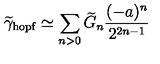

In [ ]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image

In [ ]:
labels = encoding['labels']
labels[labels == -100] = tokenizer.token_to_id("[PAD]")
label_str = tokenizer.decode(labels.tolist(), skip_special_tokens=True)
print(label_str)

\ widetilde \ gamma _ { \ mathrm { h o p f } } \ simeq \ sum _ { n > 0 } \ widetilde { G } _ { n } { \ frac { ( - a ) ^ { n } } { 2 ^ { 2 n - 1 } } }


In [ ]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size) # changed batch_size

# Train autoencoder

In [ ]:
#  defining encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        # conv layer (depth from 3 --> 8), 3x3 kernels
        self.conv1 = nn.Conv2d(3, 8, 3, padding=1)
        # conv layer (depth from 8 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(8, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        output = self.pool(x)  # compressed representation
        return output


#  defining decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 8, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(8, 3, 2, stride=2)

    def forward(self, x):
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        output = torch.sigmoid(self.t_conv2(x))
        return output


#  defining autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encode(self, x):
      return self.encoder(x)

    def decode(self, x):
      return self.decoder(x)

model = ConvAutoencoder()
model.to(device)

ConvAutoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Decoder(
    (t_conv1): ConvTranspose2d(4, 8, kernel_size=(2, 2), stride=(2, 2))
    (t_conv2): ConvTranspose2d(8, 3, kernel_size=(2, 2), stride=(2, 2))
  )
)

In [ ]:
model.tokenizer = tokenizer
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
criterion = nn.MSELoss()

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
model.train()
for epoch in range(num_epoch):
    model.train()
    train_loss = 0.0

    for i, batch in enumerate(tqdm(train_dataloader)):
        for key,value in batch.items():
            batch[key] = value.to(device) # move dict to GPU

        outputs = model(batch["pixel_values"])
        loss = criterion(outputs, batch["pixel_values"])
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()*batch["pixel_values"].size(0)
        if i % report_step == 0: print(f"Loss: {loss.item()}")

    print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))


  0%|          | 0/295 [00:00<?, ?it/s]

Loss: 0.31506749987602234
Loss: 0.25342708826065063
Loss: 0.1602988839149475
Loss after epoch 0: 53.659357904125066


  0%|          | 0/295 [00:00<?, ?it/s]

Loss: 0.10410380363464355
Loss: 0.07833226770162582
Loss: 0.06768297404050827
Loss after epoch 1: 19.263692292065944


  0%|          | 0/295 [00:00<?, ?it/s]

Loss: 0.06188056990504265
Loss: 0.0583958700299263
Loss: 0.0576535239815712
Loss after epoch 2: 14.788521574526015


In [ ]:
torch.save(model.state_dict(), './results/model1.pth')
torch.save(optimizer.state_dict(), './results/optimizer1.pth')

In [ ]:
model = ConvAutoencoder()
model.to(device)
model.eval()
model.load_state_dict(torch.load('./results/model.pth'))

<All keys matched successfully>

In [ ]:
eval_loss = 0.0
epoch = 2
for i, batch in enumerate(tqdm(eval_dataloader)):
    for key,value in batch.items():
        batch[key] = value.to(device) # move dict to GPU

        outputs = model(batch["pixel_values"])
        loss = criterion(outputs, batch["pixel_values"])

        px = batch["pixel_values"][0].cpu().numpy()
        # labels = batch["labels"][i]
        generated = outputs[0].cpu().detach().numpy()

        eval_loss += loss.item()*batch["pixel_values"].size(0)
    if i % report_step == 0: print(f"Loss: {loss.item()}")

    print(f"Loss after epoch {epoch}:", eval_loss/len(eval_dataloader))

  0%|          | 0/33 [00:00<?, ?it/s]

Loss: 0.026438815519213676
Loss after epoch 2: 0.41020222866173944
Loss after epoch 2: 0.8163713108409535
Loss after epoch 2: 1.2135026816165808
Loss after epoch 2: 1.6308613979455195
Loss after epoch 2: 2.0481091412630947
Loss after epoch 2: 2.4425515839547822
Loss after epoch 2: 2.8647475098118638
Loss after epoch 2: 3.2698404427730674
Loss after epoch 2: 3.696050788417007
Loss after epoch 2: 4.087572675762755
Loss after epoch 2: 4.493049910574248
Loss after epoch 2: 4.909834225972493
Loss after epoch 2: 5.324932965365323
Loss after epoch 2: 5.732578479882442
Loss after epoch 2: 6.119030258872292
Loss after epoch 2: 6.546094085230972
Loss after epoch 2: 6.957338015238444
Loss after epoch 2: 7.3708090637669414
Loss after epoch 2: 7.771260550527861
Loss after epoch 2: 8.186247999017889
Loss after epoch 2: 8.60037612915039
Loss after epoch 2: 9.007757475881865
Loss after epoch 2: 9.43299660538182
Loss after epoch 2: 9.826276316787258
Loss after epoch 2: 10.240334424105557
Loss after epo

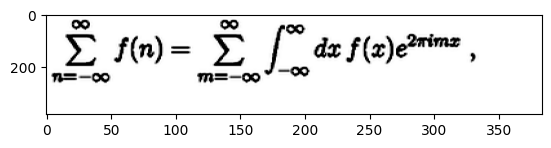

In [ ]:
plt.imshow(px.transpose([1,2,0]), aspect=1/5)

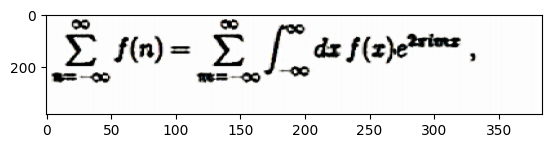

In [ ]:
plt.imshow(generated.transpose([1,2,0]), aspect=1/5)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=1)
latent_im = []

for i, batch in enumerate(tqdm(test_dataloader)):
    for key,value in batch.items():
        batch[key] = value.to(device)

        outputs = model.encode(batch["pixel_values"].to(device))
        latent_im.append(outputs.cpu())
        break


  0%|          | 0/10355 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 22240 has 14.74 GiB memory in use. Of the allocated memory 14.59 GiB is allocated by PyTorch, and 24.68 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
latent_im = torch.stack(latent_im,dim=0)
print(latent_im.shape)

torch.Size([1377, 1, 4, 96, 96])


In [ ]:
print(latent_im)

tensor([[[[[2.2082e+01, 1.2844e+01, 1.2844e+01,  ..., 1.2844e+01,
            1.2844e+01, 1.2351e+01],
           [2.2352e+01, 1.2868e+01, 1.2868e+01,  ..., 1.2868e+01,
            1.2868e+01, 1.2367e+01],
           [2.2352e+01, 1.2868e+01, 1.2868e+01,  ..., 1.2868e+01,
            1.2868e+01, 1.2367e+01],
           ...,
           [2.2352e+01, 1.2868e+01, 1.2868e+01,  ..., 1.2868e+01,
            1.2868e+01, 1.2367e+01],
           [2.2352e+01, 1.2868e+01, 1.2868e+01,  ..., 1.2868e+01,
            1.2868e+01, 1.2367e+01],
           [2.2118e+01, 1.2757e+01, 1.2757e+01,  ..., 1.2757e+01,
            1.2757e+01, 1.2257e+01]],

          [[1.9390e+01, 1.8188e+01, 1.8188e+01,  ..., 1.8188e+01,
            1.8188e+01, 2.0498e+01],
           [2.0378e+01, 1.9102e+01, 1.9102e+01,  ..., 1.9102e+01,
            1.9102e+01, 2.1470e+01],
           [2.0378e+01, 1.9102e+01, 1.9102e+01,  ..., 1.9102e+01,
            1.9102e+01, 2.1470e+01],
           ...,
           [2.0378e+01, 1.9102e+01, 1.9

In [ ]:
torch.save(latent_im, './results/latent_im.pt')